#Preprocessing

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string #to check for punctuation, removing unwanted characters
import nltk
from nltk.corpus import stopwords #to remove stopwords from text
from wordcloud import WordCloud #for text visualization
nltk.download('stopwords')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer #convert string words into integers
from tensorflow.keras.preprocessing.sequence import pad_sequences #for padding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #to stop training if the performance is not increasing significantly or is starting to decrease

import warnings
warnings.filterwarnings('ignore') #to ignore warnings if any


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Load the labeled Email dataset

In [2]:
url = "https://raw.githubusercontent.com/Bilmis/Email-Spam-Classifier/aad7d0bdc4a18e8b7feadb5ed4b1e0f58324793c/spam_ham_dataset.csv"
df=pd.read_csv(url)
print(df.head())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\nth...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\n( see a...   
2        3624   ham  Subject: neon retreat\nho ho ho , we ' re arou...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\nthis deal is to ...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


In [3]:
print(df.columns) #label_num=1 means spam , =0 means not spam
print(df.shape)

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')
(5171, 4)


visualize the data using seaborn

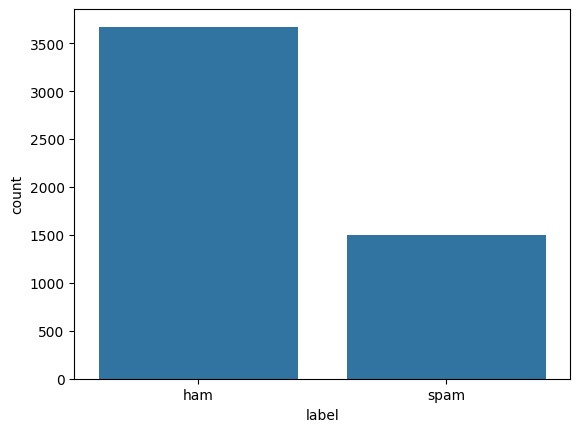

In [4]:
sns.countplot(x='label',data=df)
plt.show()
#we have around 3500 normal emails and around 1500 spam emails

The ham and spam data is not balanced(ham is more) we need to balance it

In [5]:
ham_data=df[df['label']=='ham']
spam_data=df[df['label']=='spam']
print(ham_data.shape)
print(spam_data.shape)

(3672, 4)
(1499, 4)


In [6]:
ham_data_balanced=ham_data.sample(n=len(spam_data),random_state=42) #random_state=42 to ensure that sampling is reproducible
print("Ham data balanced")
print(ham_data_balanced.head())
balanced_data=pd.concat([ham_data_balanced,spam_data],axis=0).reset_index(drop=True)
print("Balanced Data")
print(balanced_data.tail())

Ham data balanced
      Unnamed: 0 label                                               text  \
2977        3444   ham  Subject: conoco - big cowboy\ndarren :\ni ' m ...   
3822        2982   ham  Subject: feb 01 prod : sale to teco gas proces...   
2257        2711   ham  Subject: california energy crisis\ncalifornia ...   
2786        3116   ham  Subject: re : nom / actual volume for april 23...   
4551        1314   ham  Subject: eastrans nomination changes effective...   

      label_num  
2977          0  
3822          0  
2257          0  
2786          0  
4551          0  
Balanced Data
      Unnamed: 0 label                                               text  \
2993        4381  spam  Subject: pictures\nstreamlined denizen ajar ch...   
2994        4979  spam  Subject: penny stocks are about timing\nnomad ...   
2995        4162  spam  Subject: anomaly boys from 3881\nuosda apaprov...   
2996        4365  spam  Subject: slutty milf wants to meet you\ntake t...   
2997        

visualize the new balaced data

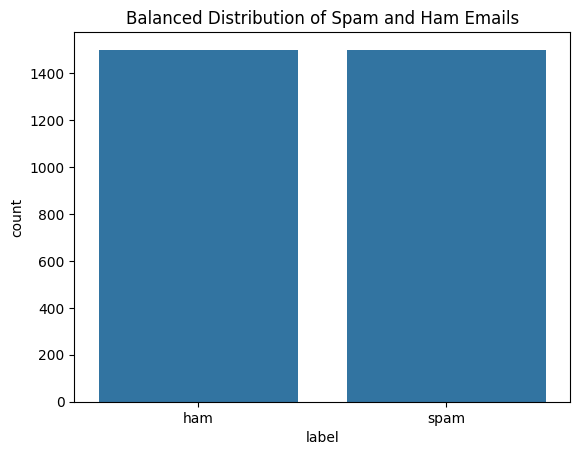

In [7]:
sns.countplot(x='label',data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.show()

Text cleaning- Stopwords,Punctuations etc
perform stemming/lemmatization

In [8]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '', regex=False) #remove the word 'Subject' from the email texts
print(balanced_data.head())

   Unnamed: 0 label                                               text  \
0        3444   ham  : conoco - big cowboy\ndarren :\ni ' m not sur...   
1        2982   ham  : feb 01 prod : sale to teco gas processing\ns...   
2        2711   ham  : california energy crisis\ncalifornia  , s p...   
3        3116   ham  : re : nom / actual volume for april 23 rd\nwe...   
4        1314   ham  : eastrans nomination changes effective 8 / 2 ...   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0  


remove punctuations

In [9]:
#removing punctuations
def remove_punctuations(text):
  punctuations_list=string.punctuation
  for punctuation in punctuations_list:
    text=text.replace(punctuation,'')
  return text

balanced_data['text']=balanced_data['text'].apply(remove_punctuations)#applyies the removepunctuations function to each row in the column 'text'
print(balanced_data.head())

   Unnamed: 0 label                                               text  \
0        3444   ham   conoco  big cowboy\ndarren \ni  m not sure if...   
1        2982   ham   feb 01 prod  sale to teco gas processing\nsal...   
2        2711   ham   california energy crisis\ncalifornia   s pow...   
3        3116   ham   re  nom  actual volume for april 23 rd\nwe ag...   
4        1314   ham   eastrans nomination changes effective 8  2  0...   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0  


remove stopwords

In [10]:
#removing stop words
def remove_stopwords(text):
  #stop_words=stopwords.words('english')
  stop_words=set(stopwords.words('english'))
  imp_words=[] #for storing important words

  words=str(text).split()
  for word in words:
    word=word.lower()
    if word not in stop_words:
      imp_words.append(word)

  output= " ".join(imp_words)
  return output
balanced_data['text']=balanced_data['text'].apply(remove_stopwords)
#balanced_data['text']=balanced_data['text'].apply(lambda text: remove_stopwords(text))
  #u can also use a lamda function to apply to every row in the text column explicitly by using - balanced_data['text']=balanced_data['text'].apply(lamda x: remove_stopwords(x))
print(balanced_data.head())

   Unnamed: 0 label                                               text  \
0        3444   ham  conoco big cowboy darren sure help know else a...   
1        2982   ham  feb 01 prod sale teco gas processing sale deal...   
2        2711   ham  california energy crisis california  power cr...   
3        3116   ham  nom actual volume april 23 rd agree eileen pon...   
4        1314   ham  eastrans nomination changes effective 8 2 00 p...   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0  


visualization of the text using wordcloud

All cleaned words in emailconoco big cowboy darren sure help know else ask april may gas pathed deal 133304 conoco gepl big cowboy point conoco saying buy gas accounted hpl big cowboy gas think paid 1 5 mil month gepl gas know added gepl meter deal april could bought gas someone else meter statements tejas say supply company megan feb 01 prod sale teco gas processing sale deal 235670 expired 12 00 julie deal expired teco gas processing sale 02 01 deal extended pls let know redraft sale unify katherine 5 8643 unable draft volume unify due expired deal ticket california energy crisis california  power crisis generated heated debate last several months unfortunately debate generated heat light want know facts crisis please spend minutes reading following overview situation position california energy issues happened california source california  current problem straightforward supply demand california  economy grew 29 percent since 1998 increased demand electricity 24 percent time regul

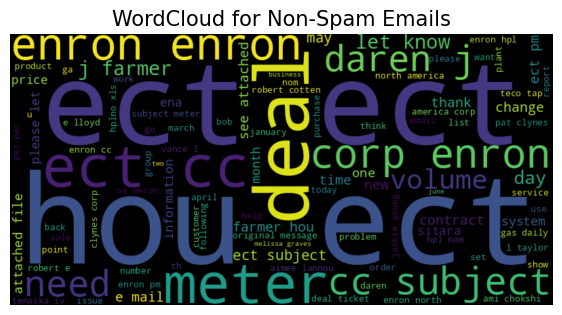

All cleaned words in emailphotoshop windows office cheap main trending abasements darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clears bayda inconveniencing managing represented smartness hashish academies shareholders unload badness danielson pure caffein spaniard chargeable levin looking medication best source difficult make material condition better best law easy enough ruin bad laws excuse found best simpliest site medication net perscription easy delivery private secure easy better see rightly pound week squint million got anything ever want erection treatment pills anti depressant pills weight loss http splicings bombahakcx com 3 knowledge human power synonymous high quality stuff low rates 100 moneyback guarantee god nature sufficeth unto wise hath need author vocable rnd word asceticism vcsc brand new stock attention vocalscape inc stock symbol vcsc 

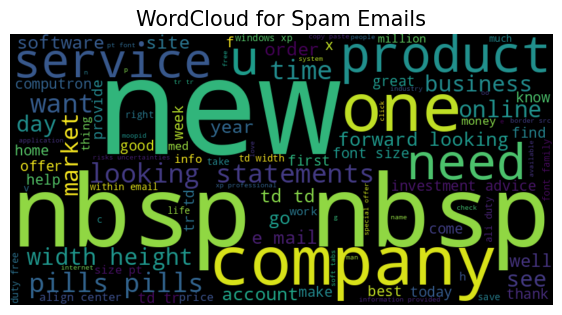

'\n# 3. Combine all cleaned text into one string\ntext_data = " ".join(balanced_data[\'text\'].tolist())\n\n# 4. Generate WordCloud\nwordcloud = WordCloud(\n    width=800,\n    height=400,\n    background_color=\'white\',\n    colormap=\'viridis\',  # Optional: change the color palette\n    max_words=200         # Optional: limit the number of words\n).generate(text_data)\n\n# 5. Display the WordCloud\nplt.figure(figsize=(15, 7))\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.title("WordCloud of Balanced Email Text Data", fontsize=18)\nplt.show()\n'

In [11]:
#just for reference
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text']) #necessary because the WordCloud class expects one long string of text.
    print("All cleaned words in email"+email_corpus)
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear') #Displays the WordCloud image using imshow().interpolation='bilinear' smooths the image, making it look less pixelated.
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off') #hides y axis and x axis
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')


"""
# 3. Combine all cleaned text into one string
text_data = " ".join(balanced_data['text'].tolist())

# 4. Generate WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  # Optional: change the color palette
    max_words=200         # Optional: limit the number of words
).generate(text_data)

# 5. Display the WordCloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Balanced Email Text Data", fontsize=18)
plt.show()
"""

Perform tokenization and padding

*tokenization is done to convert text data into numerical vectors
cuz ML models work with numbers

*padding ensures that all text sequences have the same length so that they're compatible with the model.Neural networks expect inputs to be of fixed shape — padding ensures every email has exactly 100 tokens, whether short or long

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    balanced_data['text'],
    balanced_data['label'],
    test_size=0.2,
    random_state=42
)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train)#Learns the word index (i.e., vocabulary) from the training data. each word get assigned to a unique integer

train_sequences=tokenizer.texts_to_sequences(x_train) #Converts each email in x_train from a string to a list of integers (each integer = a word ID).
test_sequences=tokenizer.texts_to_sequences(x_test)#Applies the same word-to-integer mapping to the test data.
#Important: Words in x_test that were not seen in x_train will be ignored (treated as unknown).

max_len=100 #the maximum sequence length
train_padded=pad_sequences(train_sequences,maxlen=max_len,padding='post',truncating='post')

test_padded=pad_sequences(test_sequences,maxlen=max_len,padding='post',truncating='post')

print(train_padded)
print(type(train_padded))

y_train=(y_train=='spam').astype(int) #convert labels into binary values #(y_train== 'spam') creates a boolean array:True where the label is 'spam' and False where the label is 'ham'
y_test=(y_test=='spam').astype(int)

[[ 306   48  417 ...    0    0    0]
 [ 713  241  523 ...    0    0    0]
 [1710   48  209 ...    0    0    0]
 ...
 [ 359 1059  830 ...  385  683  745]
 [   3  373  288 ...    0    0    0]
 [1829    5  107 ... 1555 1128 1915]]
<class 'numpy.ndarray'>


# Model Creation and Training

Define the model

In [13]:
model=Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32,input_length=max_len),#The Embedding layer turns word indices into dense vectors (continuous-valued feature representations). It’s the first layer in your model that handles text.
    LSTM(16),#Long short-term memory layer-LSTM is a type of Recurrent Neural Network (RNN) that’s really good at processing sequences like text.
    Dense(units=32,activation='relu'),
    Dense(units=1,activation='linear')#output layer - here ive used from_logits=True...so instead pf sigmoid u should give linear
    ])

#16 here is the : number of LSTM cells (e.g., 16)
#LSTM reads the sequence of word embeddings and keeps track of what came before using memory cells.
#🧠 Why use it?
#It captures the order and context of words — useful in identifying patterns typical of spam or non-spam
#Embedding → gives meaning to each word
#LSTM → understands the sequence of those words

model.compile(loss=BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy','precision','recall'])

"""
#this was my method which got 0.92 accuracy
model=Sequential([
    Dense(units=35,activation='relu'),
    Dense(units=25,activation='relu'),
    Dense(units=1,activation='linear')
    ])
model.compile(loss=BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy','precision','recall'])
"""
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

We use the Embedding + LSTM layer combination when we want to process sequences of text (or other ordered categorical data) and capture both:

🧠 The meaning of individual words (via the Embedding layer)

🔁 The order and context of those words (via the LSTM layer)

✅ Common Use Cases:
📧 Spam detection (like your email classifier)

💬 Sentiment analysis (positive/negative review)

🧠 Text classification (e.g., news category prediction)

🗣️ Chatbots / conversational models

✍️ Language modeling / text generation

🔍 Named entity recognition

🎯 Sequence tagging (like part-of-speech tagging)

Train the model

We train the model using** EarlyStopping** and **ReduceLROnPlateau** callbacks. These callbacks help stop the training early if the model’s performance doesn’t improve and reduce the learning rate to fine-tune the model.

In [14]:
#model.fit(train_padded,y_train,epochs=50,validation_data=(test_padded,y_test))
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_padded, y_train,
    validation_data=(test_padded, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4963 - loss: 0.6875 - precision: 0.1504 - recall: 0.0098 - val_accuracy: 0.9617 - val_loss: 0.3003 - val_precision: 0.9309 - val_recall: 0.9930 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9572 - loss: 0.2206 - precision: 0.9462 - recall: 0.9700 - val_accuracy: 0.9617 - val_loss: 0.1607 - val_precision: 0.9613 - val_recall: 0.9579 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9623 - loss: 0.1593 - precision: 0.9732 - recall: 0.9527 - val_accuracy: 0.9650 - val_loss: 0.1502 - val_precision: 0.9714 - val_recall: 0.9544 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9694 - loss: 0.1370 - precision: 0.9781 - recall: 0.9626 - val_accuracy: 0.9567 - val_loss: 0.1755 - val_precision: 0.9744 - val_recall: 0.9333 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.952

**ES**:

Stops training if val_accuracy doesn't improve for 3 consecutive epochs.(patience=3)

restore_best_weights=True: After stopping, it restores the model weights from the epoch with the best validation accuracy.


**LR**:

If val_loss doesn't improve for 2 consecutive epochs, the learning rate is reduced by a factor of 0.5 (i.e., halved).

Helps the optimizer take smaller steps when learning slows down, often leading to better convergence.


# Model Evaluation

In [15]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9734 - loss: 0.1247 - precision: 0.9715 - recall: 0.9736
Test Loss: 0.13403654098510742
Test Accuracy: 0.9700000286102295
Test Precision: 0.9750889539718628
Test Recall: 0.961403489112854


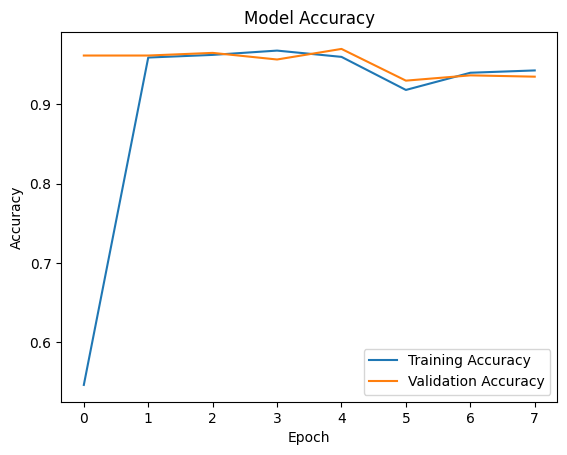

In [16]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

history.history is a dictionary that stores the training and validation metrics recorded during each epoch of model training.

When you run model.fit(...), the returned history object contains the performance metrics for every epoch — including:

Loss

Accuracy

Validation loss (val_loss)

Validation accuracy (val_accuracy)

And any additional metrics like precision or recall if you included them

history.history = {
    'loss': [0.65, 0.52, 0.44, ...],
    'accuracy': [0.70, 0.80, 0.85, ...],
    'val_loss': [0.60, 0.50, 0.49, ...],
    'val_accuracy': [0.72, 0.79, 0.82, ...]
}


# Saving the model

In [17]:
model.save('Spam_classifier_model.keras')

In [18]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Making Prediction

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the model and tokenizer
model = tf.keras.models.load_model("Spam_classifier_model.keras")

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

max_len = 100  # Same as used during training
def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    """
    punctuations_list = string.punctuation
    for punctuation in punctuations_list:
      text = text.replace(punctuation, '')
    """
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    imp_words = []
    words = str(text).split()

    for word in words:
        word = word.lower()
        if word not in stop_words:
            imp_words.append(word)

    return " ".join(imp_words)

    """
    words = text.split()
    words = [word for word in words if word not in stop_words]

    return " ".join(words)
    """
def predict_email(text):

    cleaned_text = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned_text]) #his converts the input email text into a sequence of integers using the same tokenizer you trained earlier.
                                               #Example: "win money now" → [14, 27, 56]
                                               #You must wrap text in a list ([text]) because the tokenizer expects a list of text
    data_padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(data_padded)[0][0] #model.predict(padded) returns a NumPy array like [[0.9123]]. [0][0] extracts the actual number → 0.9123.

    return "spam" if pred >= 0.5 else "not spam"


In [123]:
#email = "Congratulations! You've won a $1000 gift card. Click to claim now!"
#email="Hi John,I hope you're doing well. I wanted to remind you about the project sync meeting scheduled for tomorrow at 2:00 PM. We'll be discussing the progress, next steps, and any roadblocks we might be facing.Please let me know if you have any topics you'd like to add to the agenda.Looking forward to our discussion.Best,Sarah ThompsonProject Manager, Tech Innovators Inc.sarah.thompson@techinnovators.com(555) 123-4567"
email=input("Enter the email: ")
print(predict_email(email))


Enter the email: Hi John,  I hope you're doing well. I wanted to remind you about the project sync meeting scheduled for tomorrow at 2:00 PM. We'll be discussing the progress, next steps, and any roadblocks we might be facing.  Please let me know if you have any topics you'd like to add to the agenda.  Looking forward to our discussion.  Best, Sarah Thompson Project Manager, Tech Innovators Inc. sarah.thompson@techinnovators.com (555) 123-4567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
not spam


END!!!!